Here I'm going to try and solve the following master equation where

$$
\frac{d\rho}{dt} = -i[H_{S}, \rho] - \sum_{a,b} M_{ab}\mathcal{E}_{ab}
$$

Where 

$$
H_{S} = H_{SL} + H_{SP}
$$

- $ H_{SL} $ is the Logic Hamiltonian for the adiabatic calculation.
- $ H_{SP} $ is the sum of penalty terms.

$$ 
$H_{SL}(t) = \Omega(t)X_{L}^{\otimes n} + \Delta(t)Z_{L}^{\otimes n}$
$$
$$ 
H_{SP}(t) = -E_{P} \sum_{k} g_k
$$

and 

$$
M_{ab} = \sum_i \left[N_{ba}|g_{ba}|^2 \langle a|\sigma^{(i)}_{-} |b\rangle \langle b| \sigma^{(i)}_{+} |a\rangle + (N_{ab} + 1)|g_{ab}|^2 \langle b|\sigma^{(i)}_{-} |a\rangle h_a \sigma^{(i)}_{+} |b\rangle \right]
$$
$$
\mathcal{E}_{ab}(\rho) = |a\rangle \langle a| \rho + \rho |a\rangle \langle a| - 2 |b\rangle \langle a| \rho |a\rangle \langle b|
$$

This is just a const and we assume $N_{ba} = \frac{1}{\exp[\beta(\omega_b - \omega_a)] - 1} = 0$ , so we claim $M_{ab} = \sqrt{\gamma_{n}}$

If we denote $|b\rangle \langle a| = A_{n}$ so $|a\rangle \langle b| = A_{n}^{\dagger}$, and lets denote $C_n = \sqrt{\gamma_n} A_{n}$ are the collapse operators.

the first equation $\frac{d\rho}{dt} = -i[H_{S}, \rho] - \sum_{a,b} M_{ab}\mathcal{E}_{ab}$ gets the form 

$$
\frac{d\rho}{dt} = -i[H_{S}, \rho] - \sum_{a,b} M_{ab}\mathcal{E}_{ab} = -i[H_{S}, \rho] + \sum_{n} \frac{1}{2}[2C_{n}\rho(t) C_{n}^{\dagger} - \rho(t)C_{n}^{\dagger} C_{n} - C_{n}^{\dagger} C_{n}\rho(t)]
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

In [28]:
def print_quantum_state_as_superposition(state):
    """
    Helper function to print quantum state as superposition of basis functions
    """
    state = state.unit()
    dimension = int(np.log2(state.shape[0]))
    state_vector = state.full().flatten()
    basis_states = ['0', '1']
    
    superposition = []
    for i, amplitude in enumerate(state_vector):
        abs_amplitude = np.abs(amplitude)

        if round(abs_amplitude, 2) > 0:
            sign = '-' if amplitude.real < 0 else '+'
            binary_state = ''.join(basis_states[int(bit)] for bit in f"{i:0{dimension}b}")
            superposition.append(f"{sign} {abs_amplitude:.2f}|{binary_state}⟩")

    # Removing the first sign
    if superposition and superposition[0][0] == '+':
        superposition[0] = superposition[0][2:]

    superposition_str = ' '.join(superposition).replace('+-', '- ')
    
    print(f"|ψ⟩ = {superposition_str}")

def is_stabilized(state, stabilizers):
    """
    Check if a state is stabilized
    """
    stabilized = True
    syndrome = []
    overlaps = []
    for stabilizer in stabilizers:
        overlap = state.overlap(stabilizer * state)
        overlaps.append(np.abs(overlap))
        if not np.real(overlap) > 0.99:
            stabilized = False
            syndrome.append(1)
        else:
            syndrome.append(0)
            
    return syndrome, stabilized, overlaps

Text(0.5, 1.0, 'Pulses over time')

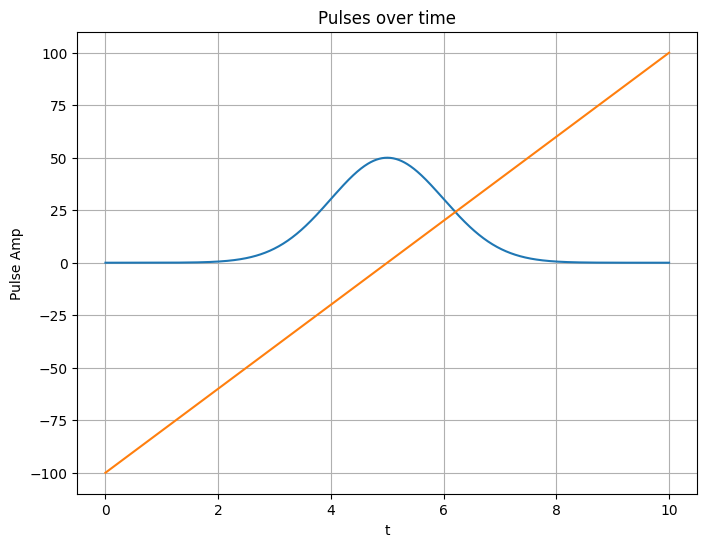

In [250]:
# defining time dependant coefs
T = 10
t = np.linspace(0, T, 1000)
sigma = 1
omega_t = 50 * np.exp(-0.5 * ((t - T/2) / sigma) ** 2)

delta_t = 100*(t / (T/2) - 1)

# Plot the wave
plt.figure(figsize=(8, 6))
plt.plot(t, omega_t)
plt.plot(t, delta_t)
plt.xlabel("t")
plt.ylabel("Pulse Amp")
plt.grid(True)
plt.title("Pulses over time")


In [251]:
I = qeye(2)
X = sigmax()
Y = sigmay()
Z = sigmaz()

# Define the stabilizer generators for the 5-qubit bit-flip code
g1 = tensor(X, Z, Z, X, I)
g2 = tensor(I, X, Z, Z, X)
g3 = tensor(X, I, X, Z, Z)
g4 = tensor(Z, X, I, X, Z)

stabilizers = [
    g1,
    g2,
    g3,
    g4
]

H_x = tensor(sigmax(), sigmax(), sigmax(), sigmax(), sigmax())
H_z = tensor(sigmaz(), sigmaz(), sigmaz(), sigmaz(), sigmaz())

# g1 = tensor(X, X, X, X)
# g2 = tensor(Z, Z, Z, Z)
# g3 = tensor(X, Y, Z, I)
# 
# stabilizers = [
#     g1,
#     g2,
#     g3
# ]

# H_x = tensor(sigmax(), sigmax(), sigmax(), sigmax())
# H_z = tensor(sigmaz(), sigmaz(), sigmaz(), sigmaz())


In [252]:
basis_states = [basis(2, 0), basis(2, 1)]

# Define the logical zero state |0_L>
logical_zero = (tensor(basis_states[0], basis_states[0], basis_states[0], basis_states[0], basis_states[0]) +
                tensor(basis_states[1], basis_states[0], basis_states[0], basis_states[1], basis_states[0]) +
                tensor(basis_states[0], basis_states[1], basis_states[0], basis_states[0], basis_states[1]) +
                tensor(basis_states[1], basis_states[0], basis_states[1], basis_states[0], basis_states[0]) +
                tensor(basis_states[0], basis_states[1], basis_states[0], basis_states[1], basis_states[0]) -
                tensor(basis_states[1], basis_states[1], basis_states[0], basis_states[1], basis_states[1]) -
                tensor(basis_states[0], basis_states[0], basis_states[1], basis_states[1], basis_states[0]) -
                tensor(basis_states[1], basis_states[1], basis_states[0], basis_states[0], basis_states[0]) -
                tensor(basis_states[1], basis_states[1], basis_states[1], basis_states[0], basis_states[1]) -
                tensor(basis_states[0], basis_states[0], basis_states[0], basis_states[1], basis_states[1]) -
                tensor(basis_states[1], basis_states[1], basis_states[1], basis_states[1], basis_states[0]) -
                tensor(basis_states[0], basis_states[1], basis_states[1], basis_states[1], basis_states[1]) -
                tensor(basis_states[1], basis_states[0], basis_states[0], basis_states[0], basis_states[1]) -
                tensor(basis_states[0], basis_states[1], basis_states[1], basis_states[0], basis_states[0]) -
                tensor(basis_states[1], basis_states[0], basis_states[1], basis_states[1], basis_states[1]) +
                tensor(basis_states[0], basis_states[0], basis_states[1], basis_states[0], basis_states[1])).unit()

# logical_X = tensor(X, X, X, X, X)
logical_X = -tensor(X, I, Y, Y, I)
logical_Y = -tensor(Z, Z, I, Y, I)
logical_Z = -tensor(Y, Z, Y, I, I)

# logical_zero = (tensor(basis_states[0], basis_states[0], basis_states[0], basis_states[0]) +
#                 1j*tensor(basis_states[0], basis_states[0], basis_states[1], basis_states[1]) +
#                 1j*tensor(basis_states[1], basis_states[1], basis_states[0], basis_states[0]) +
#                 tensor(basis_states[1], basis_states[1], basis_states[1], basis_states[1])).unit()
# 
# logical_X = tensor(Y, I, Y, I)
# logical_Y = -tensor(I, X, X, I)
# logical_Z = tensor(Z, Z, I, I)


logical_one = logical_X * logical_zero

# Applying error
# error = tensor(I, I, I, X, I)
# logical_zero = error * logical_zero
# logical_one = error * logical_one

result_zero = is_stabilized(logical_zero, stabilizers)
result_one = is_stabilized(logical_one, stabilizers)
print(f"Logical |0_L> is stabilized: {result_zero[1]} and the syndrom is {result_zero[0]}")
print(f"Logical |1_L> is stabilized: {result_one[1]} and the syndrom is {result_one[0]}")

Logical |0_L> is stabilized: True and the syndrom is [0, 0, 0, 0]
Logical |1_L> is stabilized: True and the syndrom is [0, 0, 0, 0]


In [241]:
gamma_sqrts = [0.00001]

plt.figure(figsize=(8, 6))

for gamma_sqrt in gamma_sqrts:
    Ep = 0.1
    Hp = -Ep*(g1 + g2 + g3)
    
    C_op = gamma_sqrt * sigmam()
    collapse_ops = [
        tensor(C_op, I, I, I),
        tensor(I, C_op, I, I),
        tensor(I, I, C_op, I),
        tensor(I, I, I, C_op),
    ]
    
    # Define time-dependent Hamiltonian
    H_S = [[H_x, omega_t], [H_z, delta_t], Hp]
    
    output = mesolve(H_S, logical_zero, t, collapse_ops, [])
    
    expect_psi_0 = []
    expect_psi_1 = []
    for index, state in enumerate(output.states):
        expect_stat_psi_0 = np.abs(logical_zero.overlap(state))**2
        expect_stat_psi_1 = np.abs(logical_one.overlap(state))**2
        
        expect_psi_0.append(expect_stat_psi_0)
        expect_psi_1.append(expect_stat_psi_1)
    
    eigenvalues_0 = np.array(expect_psi_0)
    eigenvalues_1 = np.array(expect_psi_1)

    # Plotting the results
    plt.plot(t, eigenvalues_0, label=r'$|\langle 0_L | \psi(t) \rangle|^2$, gamma_sqrt = {}'.format(gamma_sqrt))
    plt.plot(t, eigenvalues_1, label=r'$|\langle 1_L | \psi(t) \rangle|^2$, gamma_sqrt = {}'.format(gamma_sqrt))
    plt.legend()

plt.title(r'$| \psi(t) \rangle \ with \ initial \ conditions \ | \psi(t=0) \rangle = |0_L\rangle$')
plt.xlabel("t")
plt.ylabel("Overlap")
plt.show()

TypeError: incompatible dimensions[[[2, 2, 2, 2, 2], [2, 2, 2, 2, 2]], [[2, 2, 2, 2, 2], [2, 2, 2, 2, 2]]], [[[2, 2, 2, 2], [2, 2, 2, 2]], [[2, 2, 2, 2], [2, 2, 2, 2]]]

<Figure size 800x600 with 0 Axes>

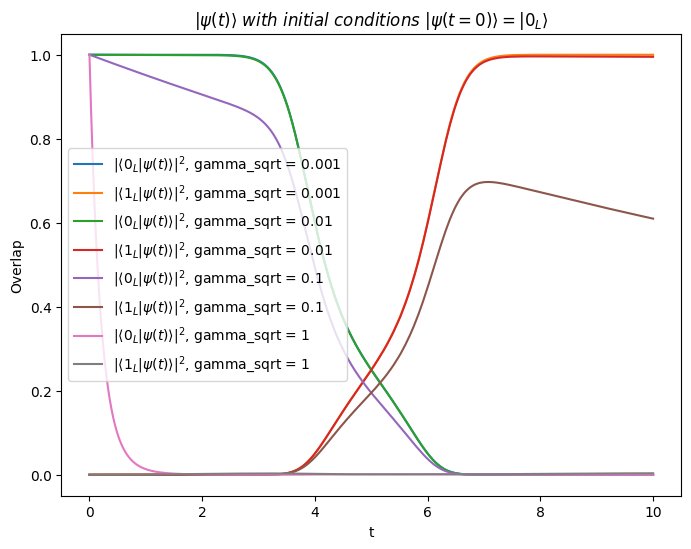

In [253]:
gamma_sqrts = [0.001, 0.01, 0.1, 1]

plt.figure(figsize=(8, 6))

for gamma_sqrt in gamma_sqrts:
    Ep = 0.01
    Hp = -Ep*(g1 + g2 + g3 + g4)
    
    C_op = gamma_sqrt * sigmam()
    collapse_ops = [
        tensor(C_op, I, I, I, I),
        tensor(I, C_op, I, I, I),
        tensor(I, I, C_op, I, I),
        tensor(I, I, I, C_op, I),
        tensor(I, I, I, I, C_op)
    ]
    
    # Define time-dependent Hamiltonian
    H_S = [[H_x, omega_t], [H_z, delta_t], Hp]
    
    output = mesolve(H_S, logical_zero, t, collapse_ops, [])
    
    expect_psi_0 = []
    expect_psi_1 = []
    for index, state in enumerate(output.states):
        expect_stat_psi_0 = np.abs(logical_zero.overlap(state))**2
        expect_stat_psi_1 = np.abs(logical_one.overlap(state))**2
        
        expect_psi_0.append(expect_stat_psi_0)
        expect_psi_1.append(expect_stat_psi_1)
    
    eigenvalues_0 = np.array(expect_psi_0)
    eigenvalues_1 = np.array(expect_psi_1)

    # Plotting the results
    plt.plot(t, eigenvalues_0, label=r'$|\langle 0_L | \psi(t) \rangle|^2$, gamma_sqrt = {}'.format(gamma_sqrt))
    plt.plot(t, eigenvalues_1, label=r'$|\langle 1_L | \psi(t) \rangle|^2$, gamma_sqrt = {}'.format(gamma_sqrt))
    plt.legend()

plt.title(r'$| \psi(t) \rangle \ with \ initial \ conditions \ | \psi(t=0) \rangle = |0_L\rangle$')
plt.xlabel("t")
plt.ylabel("Overlap")
plt.show()

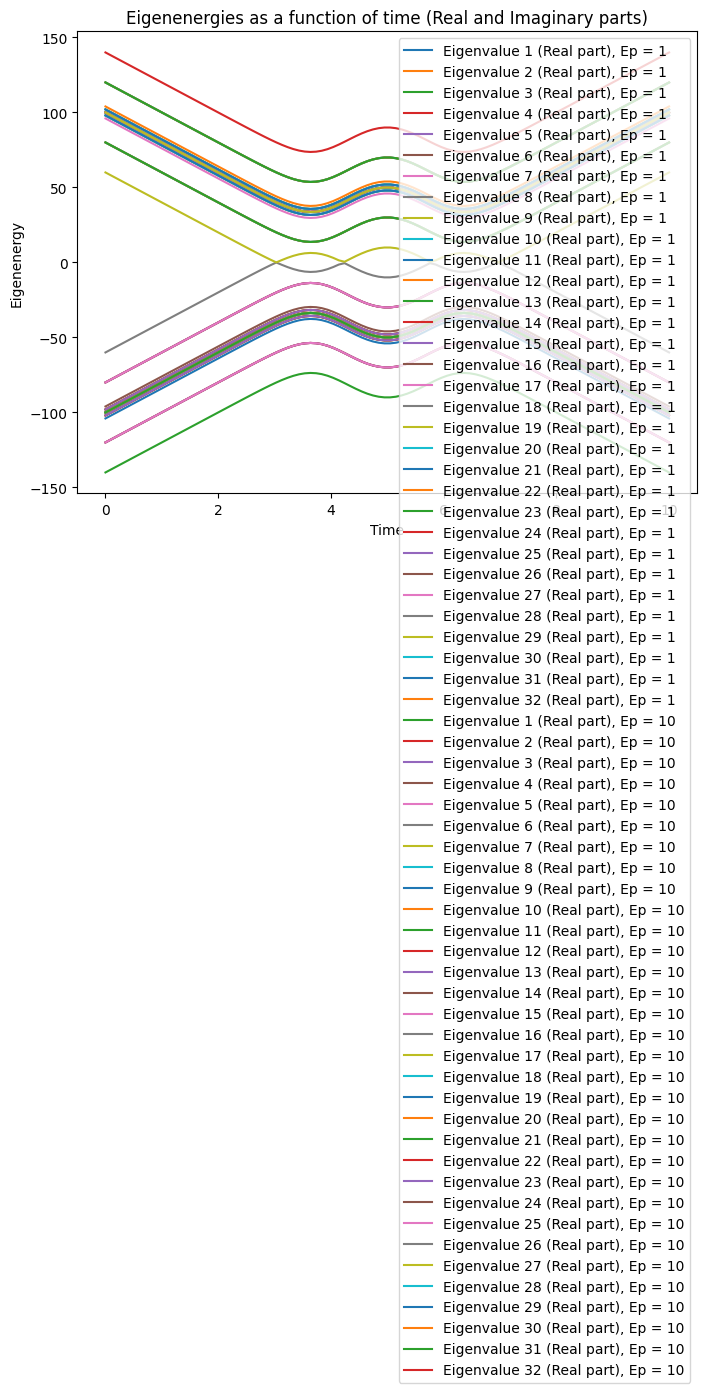

In [254]:
Eps = [1, 10]

plt.figure(figsize=(8, 6))

for Ep in Eps:
    Hp = -Ep*(g1 + g2 + g3 + g4)
    
    gamma_sqrt = 0.01
    C_op = gamma_sqrt * sigmam()
    collapse_ops = [
        tensor(C_op, I, I, I, I),
        tensor(I, C_op, I, I, I),
        tensor(I, I, C_op, I, I),
        tensor(I, I, I, C_op, I),
        tensor(I, I, I, I, C_op)
    ]
    
    omega_t_f = lambda t: 50 * np.exp(-0.5 * ((t - T / 2) / sigma) ** 2)
    
    delta_t_f = lambda t: 100 * (t / (T / 2) - 1)
    
    def get_full_hamiltonian(t_step):
        H_time_dependent = omega_t_f(t_step) * H_x + delta_t_f(t_step) * H_z + Hp
        return H_time_dependent
    
    def get_effective_hamiltonian(t_step):
        H_t = get_full_hamiltonian(t_step)
        H_eff = H_t - 0.5j * sum([c.dag() * c for c in collapse_ops])  # Non-Hermitian Hamiltonian
        return H_eff
    
    time_steps = np.linspace(0, 10, 100)  # Adjust the range and number of points
    
    eigenenergies_over_time = []
    
    # Loop over time points and calculate eigenenergies of the effective Hamiltonian
    for t_step in time_steps:
        H_eff_t = get_effective_hamiltonian(t_step)
        eigenenergies = H_eff_t.eigenenergies()
        eigenenergies_over_time.append(eigenenergies)
    
    # Convert list to numpy array for easier handling
    eigenenergies_over_time = np.array(eigenenergies_over_time)
    
    
    for i in range(eigenenergies_over_time.shape[1]):  # Loop over each eigenvalue
        plt.plot(time_steps, np.real(eigenenergies_over_time[:, i]), label=f'Eigenvalue {i+1} (Real part), Ep = {Ep}')

plt.xlabel('Time')
plt.ylabel('Eigenenergy')
plt.title('Eigenenergies as a function of time (Real and Imaginary parts)')
plt.legend()
plt.show()

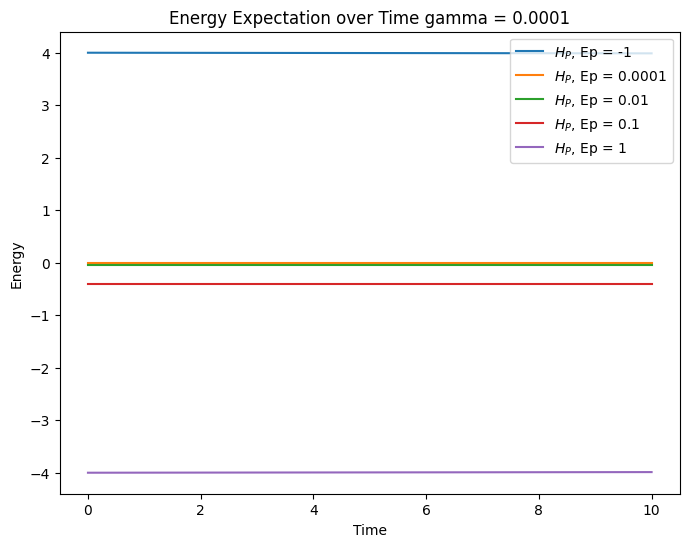

In [255]:
Eps = [-1, 0.0001, 0.01, 0.1, 1]
plt.figure(figsize=(8, 6))

for Ep in Eps:
    Hp = -Ep * (g1 + g2 + g3 + g4)
    
    H = [[H_x, omega_t], [H_z, delta_t], Hp]
    
    gamma_sqrt = 0.01
    C_op = gamma_sqrt * sigmam()
    collapse_ops = [
        tensor(C_op, I, I, I, I),
        tensor(I, C_op, I, I, I),
        tensor(I, I, C_op, I, I),
        tensor(I, I, I, C_op, I),
        tensor(I, I, I, I, C_op)
    ]
    
    energy_op = H_x + H_z + Hp
    
    # logical_zero = tensor(basis(2, 0), basis(2, 0), basis(2, 0), basis(2, 0), basis(2, 0))

    result = mesolve(H, logical_zero, t, collapse_ops, e_ops=[energy_op, H_x, H_z, logical_X, logical_Z, Hp])
    
    energy_expectation = result.expect[0]
    energy_x = result.expect[1]
    energy_z = result.expect[2]
    energy_X_L = result.expect[3]
    energy_Z_L = result.expect[4]
    energy_Hp = result.expect[5]
    
    # plt.plot(t, energy_expectation, label="Energy All Terms, Ep = {Ep}".format(Ep=Ep))
    # plt.plot(t, energy_x, label="$H_{x}$, Ep = " + str(Ep))
    # plt.plot(t, energy_z, label="$H_{z}$, Ep = " + str(Ep))
    # plt.plot(t, energy_X_L, label="$X_{L}$, Ep = " + str(Ep))
    plt.plot(t, energy_Hp, label="$H_{P}$, Ep = " + str(Ep))

plt.xlabel("Time")
plt.ylabel("Energy")
plt.title("Energy Expectation over Time gamma = " + str(gamma_sqrt**2))
plt.legend()
plt.show()

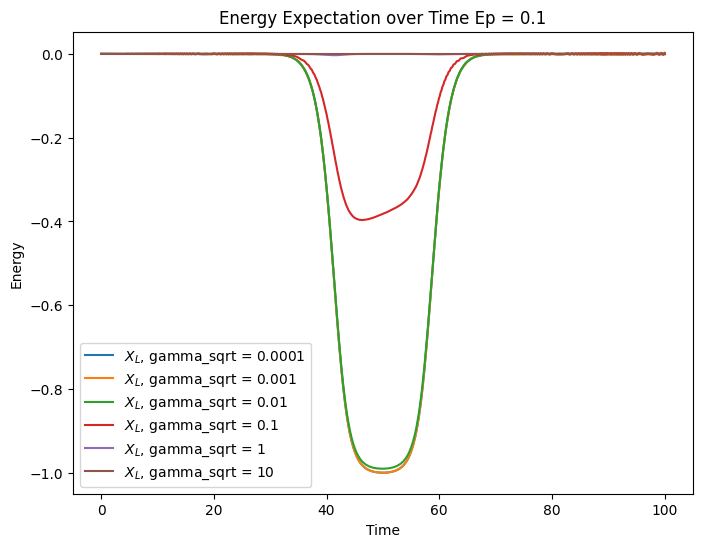

In [246]:
gamma_sqrts = [0.0001,  0.001, 0.01, 0.1, 1, 10]
plt.figure(figsize=(8, 6))

for gamma_sqrt in gamma_sqrts:
    Ep = 0.1
    Hp = -Ep * (g1 + g2 + g3 + g4)
    
    H = [[H_x, omega_t], [H_z, delta_t], Hp]
    
    C_op = gamma_sqrt * sigmam()
    collapse_ops = [
        tensor(C_op, I, I, I, I),
        tensor(I, C_op, I, I, I),
        tensor(I, I, C_op, I, I),
        tensor(I, I, I, C_op, I),
        tensor(I, I, I, I, C_op)
    ]
    
    energy_op = H_x + H_z + Hp
    
    result = mesolve(H, logical_zero, t, collapse_ops, e_ops=[energy_op, H_x, H_z, logical_X, logical_Z, Hp])
    
    energy_expectation = result.expect[0]
    energy_x = result.expect[1]
    energy_z = result.expect[2]
    energy_X_L = result.expect[3]
    energy_Z_L = result.expect[4]
    energy_Hp = result.expect[5]
    
    # plt.plot(t, energy_expectation, label="Energy All Terms, gamma_sqrt = {gamma_sqrt}".format(gamma_sqrt=gamma_sqrt))
    # plt.plot(t, energy_x, label="$H_{x}$, gamma_sqrt = " + str(gamma_sqrt))
    # plt.plot(t, energy_z, label="$H_{z}$, gamma_sqrt = " + str(gamma_sqrt))
    plt.plot(t, energy_X_L, label="$X_{L}$, gamma_sqrt = " + str(gamma_sqrt))
    # plt.plot(t, energy_Hp, label="$H_{P}$, gamma_sqrt = " + str(gamma_sqrt))

plt.xlabel("Time")
plt.ylabel("Energy")
plt.title("Energy Expectation over Time Ep = " + str(Ep))
plt.legend()
plt.show()